# Introduction

This notebook presents **lca-algebraic** a small layer above **brightay2**, designed for the definition of **parametric inventories** with fast computation of LCA impacts, suitable for **monte-carlo** analyis.

**lca-algebraic** provides a set of  **helper functions** for : 
* **compact** & **human readable** definition of activites :  
    * search background (tech and biosphere) activities 
    * create new foreground activites with parametrized amounts
    * parametrize / update existing background activities (extending the class **Activity**)
* definition 

  
# Principles 

The main idea of this libray is to move from **procedural definition** of models (slow and prone to errors) to a **declarative / purely functionnal** definition of parametric models (models as **pure functions**). 

This enables **fast computation of LCA impacts**. 
We leverage the **power of symbolic calculus** provided by the great libary [SymPy](https://www.sympy.org/en/index.html).

We define our model in a **separate DB**, as a nested combination of : 
* other foreground activities
* background activities :
    * Technical, refering **ecoinvent DB**
    * Biopshere, refering **brightway2** biosphere activities
    
The **amounts** in exchanges are expressed either as **static amounts**, or **symbolic expressions** of pre-defined **parameters**.

Each activity of our **root model** is defined as a **parametrized combination** of the **foreground activities**, which can themselves be expressed by the **background activities**.

When computing LCA for foreground models, the library develops the model as a combination of **only background activities**. It computes **once for all** the impact of **background activities** and compiles a **fast numpy** (vectorial) function for each impact, replacing each background activity by the **static value of the corresponding impact**.

By providing **large vectors** of **parameter values** to those numpy functions, we can compute LCA for **thousands of values** at a time.

![](./doc/lca-algebraic.png)


# Compatiblity with brightway2 

Under the hood, the activities we define with **lca-algebraic** are standard **brightway2** activities. 
The amounts of exchanges are stored as **float values** or **serialized as string** in the property **formula**.

Parameters are also stored in the **brightay2** projets, making it fully compatible with **brightway**.

Thus, a model defined with **lca-algebraic** is stored as a regular **bw2** projet. We can use **bw2** native support for [parametrized dataset](https://2.docs.brightway.dev/intro.html#parameterized-datasets) for computing LCAs, even if much more slower than the method explain here.

# Doc

The followng notebook explores the main functions.
Full doc is [available here](./doc/doc.html)

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import brightway2 as bw

# Custom utils defined for inter-acv
from lca_algebraic import *
import lca_algebraic

/home/rjolivet/anaconda3/envs/acv3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Init brightway2 and databases

In [2]:
# Import Ecoinvent DB (if not already done)
# Update the PATH to suit your installation
# importDb(ECOINVENT_DB_NAME, './ecoinvent 3.4_cutoff_ecoSpold02/datasets')

# Setup bw2 and detect version of ecoinvent
initDb('bw2_seminar_2017')

# We use a separate DB for defining our foreground model / activities
USER_DB = 'Geothermal database'

# This is better to cleanup the whole foreground model each time, 
# instead of relying on a state or previous run of model.
# Any persistent state is prone to errors.
resetDb(USER_DB)

# Parameters are stored at project level : reset them also
resetParams(USER_DB)

Biosphere database already present!!! No setup is needed


Db Geothermal database was here. Reseting it


# Introduction to Numpy


Numpy is a python libray for symbolic calculus. 

You write Sympy expression as you write **standard python expressions**, using **sympy symbols** in them. 


The result is then a **symbolic expression that can be manipulated**, instead of a **numeric value**.

In [3]:
from sympy import symbols 

# create sympy symbol
a = symbols("a")

# Expression are not directly evaluated 
f = a * 2 + 4 
f 

2*a + 4

In [4]:
# symbols can be replaced by values afterwards 
f.subs(dict(a=3))

10

In practice, you don't need to care about Sympy. Just remember that : 
* The parameters defined below are **instances of sympy symbols**
* Any **valid python expression** containing a **sympy symbol** will create a **sympy symbolic expression**

# Define parameters

We define the parameters of the model.

The numeric parameters are **instances of sympy 'Symbol'**. 

Thus, any python arithmetic expression composed of parameters will result in a **symbolic expression** for later evaluation, instead of a numeric result.

In [5]:
# Example of 'float' parameters

a = newFloatParam(
    'a', 
    default=0.5, min=0, max=2,  distrib=DistributionType.TRIANGLE, # Distribution type, linear by default
    description="hello world")

b = newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    description="foo bar")

share_recycled_aluminium = newFloatParam(
    'share_recycled_aluminium',  
    default=0.6, min=0, max=1, std=0.2, distrib=DistributionType.NORMAL, # Normal distrib, with std dev
    description="Share of reycled aluminium")

# Yuo can define boolean parameters, taking only discrete values 0 or 1
bool_param = newBoolParam(
    'bool_param', 
    default=1)

# Example 'enum' parameter, acting like a switch between several possibilities
# Enum parameters are not Symbol themselves
# They are a facility to represent many boolean parameters at once '<paramName>_<enumValue>' 
# and should be used with the 'newSwitchAct' method 
elec_switch_param = newEnumParam(
    'elec_switch_param', 
    values=["us", "eu"], 
    default="us", 
    description="Switch on electricty mix")

# Another example enum param
techno_param = newEnumParam(
    'techno_param', 
    values=["technoA", "technoB", "technoC"], 
    default="technoA", 
    description="Choice of techonoly")

# Get references to background activities

`utils` provide two functions for easy and fast (indexed) search of activities in reference databases : 
* **findBioAct** : Search activity in **biosphere3** db
* **findTechAct** : Search activity in **ecoinvent** db

Those methods are **faster** and **safer** than using traditionnal "list-comprehension" search : 
They will **fail with an error** if **more than one activity** matches, preventing the model to be based on a random selection of one activity.


In [6]:
# Biosphere activities
ground_occupuation = findBioAct('Occupation, industrial area')
heat = findBioAct('Heat, waste', categories=['air'])

# Technosphere activities

# You can add an optionnal location selector
alu = findTechAct("aluminium alloy production, AlMg3", loc="RER")
alu_scrap = findTechAct('aluminium scrap, new, Recycled Content cut-off')

# Elec 
eu_elec = findTechAct("market group for electricity, medium voltage", 'ENTSO-E')
us_elec = findTechAct("market group for electricity, medium voltage", 'US')

# Define the model

The model is defined as a nested combination of background activities with amounts.

Amounts are defined either as constant float values or algebric formulas implying the parameters defined above.

## Create new activities

In [7]:
# Create a new activity
activity1 = newActivity(USER_DB, # We define foreground activities in our own DB
    "first foreground activity", # Name of the activity
    "kg", # Unit
    exchanges= { # We define exhanges as a dictionarry of 'activity : amount'
        ground_occupuation:3 * b, # Amount can be a fixed value 
        heat: b + 0.2  # Amount can be a Sympy expression (any arithmetic expression of Parameters)
    })

# You can create a virtual "switch" activity combining several activities with a switch parameter
elec_mix = newSwitchAct(USER_DB, 
    "elect mix", # Name
    elec_switch_param, # Sith parameter
    { # Dictionnary of enum values / activities
        "us" : us_elec,
        "eu" : eu_elec})

## Copy and update existing activity

You can copy and update an existing background activity.

Several new helper methods have been added to the class **Activity** for easy update of exchanges.

In [8]:
alu2 = copyActivity(
    USER_DB, # The copy of a background activity is done in our own DB, so that we can safely update it                
    alu, # Initial activity : won't be altered
    "Alu2") # New name

# Update exchanges by their name 
alu2.updateExchanges({
    
    # Update amount : the special symbol *old_amount* references the previous amount of this exchange
    "aluminium, cast alloy": old_amount * (1 - share_recycled_aluminium),
    
    # Update input activity. Note also that you can use '*' wildcard in exchange name
    "electricity*": elec_mix,
    
    # Update both input activity and amount. 
    # Note that you can use '#' for specifying the location of exchange (useful for duplicate exchange names)
    "chromium#GLO" : dict(amount=4.0, input=activity1)
}) 

# Add exchanges 
alu2.addExchanges({alu_scrap :  12})

## Final model
The final model is just the root foreground activity referencing the others

In [9]:
model = newActivity(USER_DB, "model", "kg", {
    activity1 : b * 5 + a + 1, # Reference the activity we just created
    alu2: 3 * share_recycled_aluminium, 
    alu:0.4 * a}) 

## Display activities

**printAct** displays the list of all exchanges of an activity.

Note that symbolic expressions have not been evaluated at this stage

In [10]:
# Print_act displays activities as "pandas" tables
printAct(activity1) 
printAct(model)

first foreground activity (1.000000 kg)  \
                                                                         input   
Heat, waste                          'Heat, waste' (megajoule, None, ('air',))   
Occupation, industrial area  'Occupation, industrial area' (square meter-ye...   

                                                                    
                              amount               unit       type  
Heat, waste                  b + 0.2          megajoule  biosphere  
Occupation, industrial area      3*b  square meter-year  biosphere

model (1.000000 kg)  \
                                                                                   input   
Alu2#RER {user-db}                                          'Alu2' (kilogram, RER, None)   
aluminium alloy production, AlMg3#RER  'aluminium alloy production, AlMg3' (kilogram,...   
first foreground activity {user-db}          'first foreground activity' (kg, GLO, None)   

                                                                             \
                                                           amount      unit   
Alu2#RER {user-db}                     3*share_recycled_aluminium  kilogram   
aluminium alloy production, AlMg3#RER                       0.4*a  kilogram   
first foreground activity {user-db}                   a + 5*b + 1        kg   

                                                     
                                               type  
Alu2#RER {user-db}                     technosphere  
aluminium alloy production, AlMg3#RER  technosphere  
first foreground activity {user-db}    technosphere

In [11]:
# You can also compute amounts by replacing parameters with a float value 
printAct(activity1, b=1.5) 

first foreground activity (1.000000 kg)  \
                                                                         input   
Heat, waste                          'Heat, waste' (megajoule, None, ('air',))   
Occupation, industrial area  'Occupation, industrial area' (square meter-ye...   

                                                                             
                                       amount               unit       type  
Heat, waste                  1.70000000000000          megajoule  biosphere  
Occupation, industrial area  4.50000000000000  square meter-year  biosphere

In [12]:
# You print several activities at once to compare them
printAct(alu, alu2)

# Select the impacts to consider

In [13]:
# List of impacts to consider
impacts = [m for m in bw.methods if 'ILCD 1.0.8 2016' in str(m) and 'no LT' in str(m)]

# Compute LCA

We provide two methods  for computing LCA : 
* **multiLCA** : It uses **brightway2** native parametric support. It is **much slower** and kept for **comparing results**.
* **multiLCAAlgebric** : It computes an algebric expression of the model and computes LCA once for all the background activities. Then it express each impact as a function of the parameters. This expression is then compiled into 'numpy' native code, for fast computation on vectors of samples. This version is 1 million time faster.

In [14]:
# Uses brightway2 parameters
multiLCA(
    model, 
    impacts, 
                   
    # Parameters of the model
    a=1, 
    b=2, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,"resources - mineral, fossils and renewables",climate change - GWP 100a,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
model,0.01151,7.882483,0.045329,7.033544,0.000553,0.000002,0.0061,0.070459,3.416878e-07,0.257641,0.000003,3.334854e-07,0.021609,0.011564,1497.906733


In [15]:
# Compute with algebric implementation : the values should be the same
multiLCAAlgebric(
    model, # The model 
    impacts, # Impacts
    
    # Parameters of the model
    a=1, 
    b=2,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,"resources - mineral, fossils and renewables",climate change - GWP 100a,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
model,0.01151,7.882482,0.045329,7.033544,0.000553,0.000002,0.0061,0.070459,3.416878e-07,0.257641,0.000003,3.334854e-07,0.021609,0.011564,1497.906716


In [16]:
# Here is what the symbolic model looks like :
expr, _ = actToExpression(model)
expr

0.4*a*aluminium_alloy_production_almg3 + 3*share_recycled_aluminium*(12*aluminium_scrap_new_recycled_content_cut_off + 12.0*b*occupation_industrial_area + 1.59*elec_switch_param_eu*market_group_for_electricity_medium_voltage1 + 1.59*elec_switch_param_us*market_group_for_electricity_medium_voltage + 4.0*heat_waste*(b + 0.2) + market_for_aluminium_cast_alloy*(0.965 - 0.965*share_recycled_aluminium) + 0.00406*market_for_cast_iron + 0.00102*market_for_copper + 0.0305*market_for_magnesium + 0.00508*market_for_manganese + 0.00406*market_for_silicon_metallurgical_grade + 0.00203*market_for_zinc) + (3*b*occupation_industrial_area + heat_waste*(b + 0.2))*(a + 5*b + 1)

In [17]:
# You can compute several LCAs at a time :
multiLCAAlgebric(
    [alu, alu2], # The models
    
    impacts, # Impacts
    
    # Parameters of the model
    share_recycled_aluminium=0.3,
    elec_switch_param="us",
    b=4)


Param share_recycled_aluminium not required for model 'aluminium alloy production, AlMg3' (kilogram, RER, None)
Param elec_switch_param not required for model 'aluminium alloy production, AlMg3' (kilogram, RER, None)
Param b not required for model 'aluminium alloy production, AlMg3' (kilogram, RER, None)


,"resources - mineral, fossils and renewables",climate change - GWP 100a,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
"aluminium alloy production, AlMg3[RER]",0.010063,5.731382,0.035596,5.890408,0.000352,0.000001,0.004777,0.054339,2.961301e-07,0.144029,0.000002,2.358739e-07,0.016481,0.007688,4.544623
Alu2[RER],0.007194,5.088309,0.028764,4.335949,0.000366,0.000001,0.003863,0.044837,2.035257e-07,0.172125,0.000002,2.138992e-07,0.013672,0.007482,714.312596


In [18]:
# Fast computation for millions of separate samples
multiLCAAlgebric(
    model, # The model 
    impacts, # Impacts
    
    # Parameters of the model
    a=list(range(1, 1000000)), # All lists should have the same size
    b=list(range(1, 1000000)),
    share_recycled_aluminium=1,
    elec_switch_param="eu")

,"resources - mineral, fossils and renewables",climate change - GWP 100a,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
0,0.005514,7.408485e+00,0.042096,5.728531e+00,0.000612,0.000003,0.005621,0.074416,3.532155e-07,0.404082,0.000001,4.341593e-07,0.022717,0.014186,8.491727e+02
1,0.009539,9.701037e+00,0.056335,8.084694e+00,0.000753,0.000004,0.007531,0.096152,4.716676e-07,0.461693,0.000002,5.285088e-07,0.029310,0.017262,2.227391e+03
2,0.013565,1.199359e+01,0.070573,1.044086e+01,0.000894,0.000004,0.009442,0.117887,5.901196e-07,0.519305,0.000003,6.228584e-07,0.035902,0.020337,4.138408e+03
3,0.017590,1.428614e+01,0.084812,1.279702e+01,0.001034,0.000005,0.011353,0.139622,7.085716e-07,0.576917,0.000004,7.172080e-07,0.042495,0.023412,6.582226e+03
4,0.021615,1.657870e+01,0.099050,1.515318e+01,0.001175,0.000005,0.013263,0.161358,8.270237e-07,0.634528,0.000005,8.115575e-07,0.049087,0.026488,9.558844e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,4025.239794,2.292546e+06,14238.382876,2.356155e+06,140.840220,0.481568,1910.609241,21735.400925,1.184517e-01,57611.740999,0.867927,9.434942e-02,6592.498627,3075.343237,2.663979e+14
999995,4025.243820,2.292549e+06,14238.397114,2.356157e+06,140.840360,0.481568,1910.611151,21735.422660,1.184518e-01,57611.798611,0.867928,9.434952e-02,6592.505220,3075.346313,2.663985e+14
999996,4025.247845,2.292551e+06,14238.411352,2.356160e+06,140.840501,0.481569,1910.613062,21735.444396,1.184519e-01,57611.856223,0.867929,9.434961e-02,6592.511812,3075.349388,2.663990e+14
999997,4025.251870,2.292553e+06,14238.425591,2.356162e+06,140.840642,0.481569,1910.614973,21735.466131,1.184520e-01,57611.913834,0.867929,9.434971e-02,6592.518405,3075.352463,2.663995e+14


 # Statistic functions
 
 ## One at a time 
 
 We provide several functions for computing **statistics** for **local variations** of parameters (one at a time).
 
 ### oat_matrix(model, impacts)
 
 Shows a **matrix of impacts x parameters** colored according to the variation of the impact in the bounds of the parameter.

 


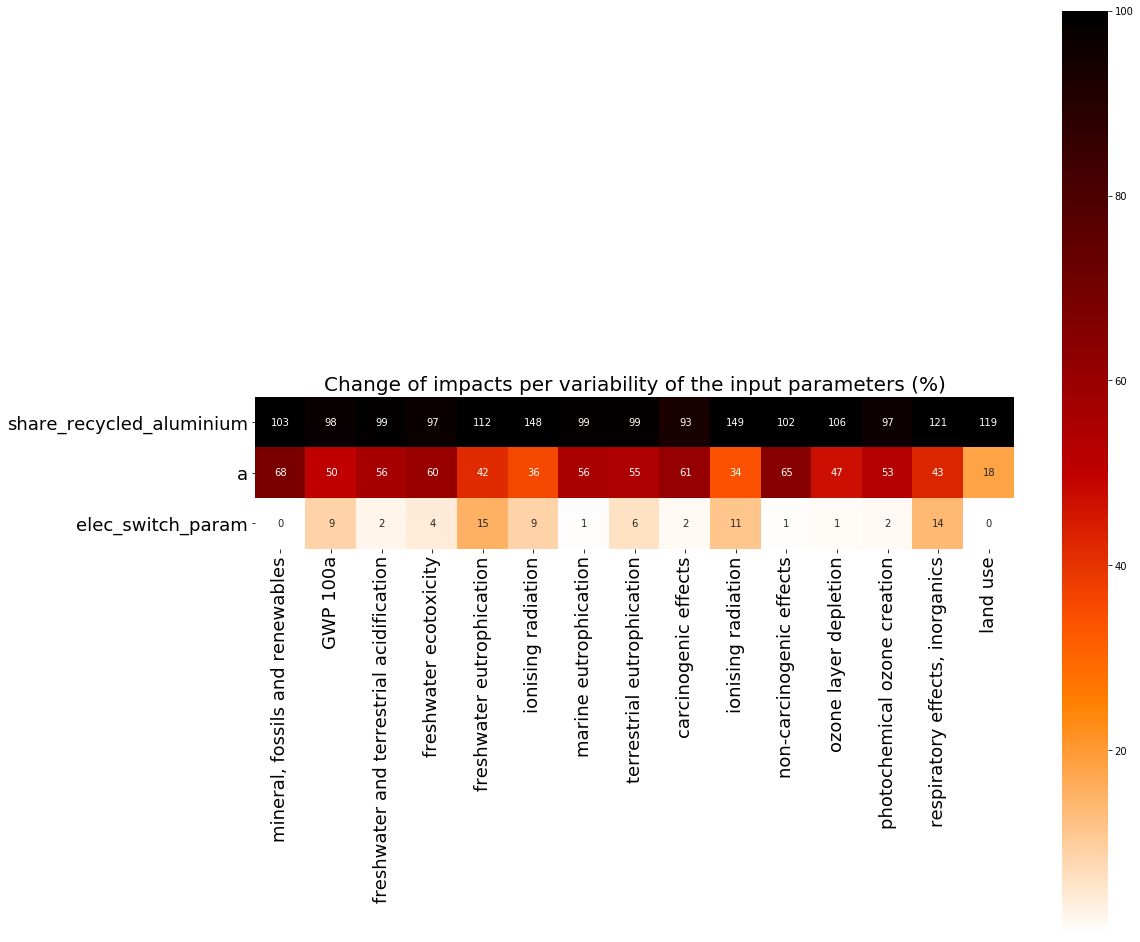

In [19]:
oat_matrix(model, impacts)

### oat_dashboard_matrix

This functions draws a dashboard showing :
* A dropdown list, for choosing a parameter
* Several graphs of evolution of impacts for this parameter
* Full table of data
* A graph of "bars" representing the variation of each impact for this parameter (similar to the information given in oat_matrix) 

In [20]:
oat_dashboard_interact(model, impacts)

interactive(children=(Dropdown(description='param', options=('share_recycled_aluminium', 'a', 'elec_switch_par…

## Monte-carlo methods & Sobol indices

Here we leverage fast computation of monte-carlo approches. 

We compute **global sensivity analysis** (GSA).
Not only local ones.


### Sobol Matrix 

Similar to OAT matrix, we compute Sobol indices. they represent the ratio between the variance due to a given parameter and the total variance.

for easier comparison, we translate those relative sobol indices into "deviation / mean" importance :

  **relative_deviation** = **sqrt**(**sobol**(param) * **total_variance**(**impact**)) / **mean**(**impact**) 




In [21]:
# Show sobol indices 
incer_stochastic_matrix(model, impacts)

Generating samples ...
Transforming samples ...
Processing LCA ...


Param bool_param not required for model 'model' (kg, GLO, None)
Param techno_param not required for model 'model' (kg, GLO, None)


Processing Sobol indices ...


interactive(children=(Dropdown(description='mode', options=(('Raw sobol indices (ST)', 'sobol'), ('Deviation (…

### Violin graphs

We provide a dashboard showing **violin graphs** : the exact probabilistic distribution for each impact. Together with medians of the impacts.

Generating samples ...
Transforming samples ...
Processing LCA ...


Param bool_param not required for model 'model' (kg, GLO, None)
Param techno_param not required for model 'model' (kg, GLO, None)


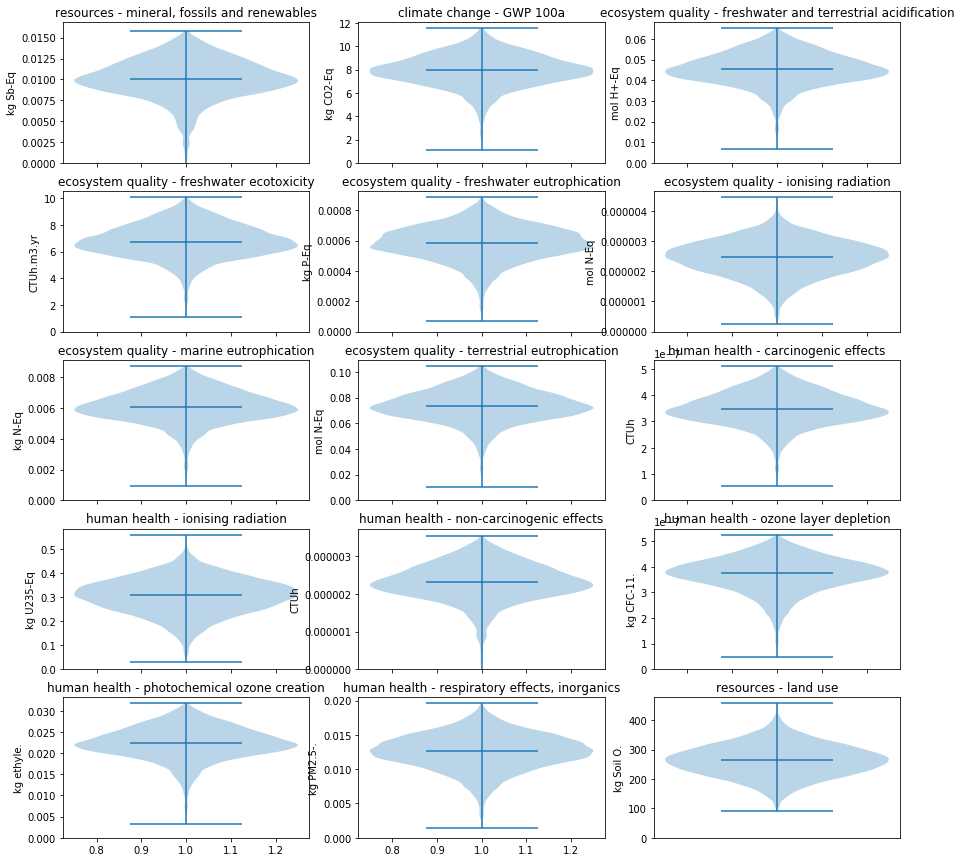

In [22]:
incer_stochastic_violin(model, impacts)

### Full dashboard

A dashboard groups all this information in a single interface with tabs.

It also shows total variation of impacts. This last graph could be improved by showing stacked colored bars with the contribution of each parameter to this variation, according to Sobol indices. 

In [23]:
incer_stochastic_dasboard(model, impacts)

Generating samples ...
Transforming samples ...
Processing LCA ...


Param bool_param not required for model 'model' (kg, GLO, None)
Param techno_param not required for model 'model' (kg, GLO, None)


Processing Sobol indices ...
